# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas_data = []

sim_altair_rv = []
sim_millstone_rv = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrMillstone.rv_with_rangelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_altair_rv.append(ssrAltair.rv_with_rangelag(rv, e))

    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    sim_meas_data.append(sim_r)

print(sim_meas_data)

[<Quantity 35325.44019592 km>, <Quantity 34871.30243306 km>, <Quantity 34416.81559206 km>, <Quantity 33961.97897874 km>, <Quantity 33506.79230523 km>, <Quantity 33051.25573733 km>, <Quantity 32595.3699471 km>, <Quantity 32139.13617115 km>, <Quantity 31682.55627556 km>, <Quantity 31225.63282792 km>, <Quantity 30768.36917765 km>, <Quantity 30310.76954545 km>, <Quantity 29852.83912298 km>, <Quantity 29394.58418425 km>, <Quantity 28936.01221005 km>, <Quantity 28477.13202708 km>, <Quantity 28017.95396389 km>, <Quantity 27558.49002561 km>, <Quantity 27098.7540902 km>, <Quantity 26638.762129 km>, <Quantity 26178.53245488 km>, <Quantity 25718.08600207 km>, <Quantity 25257.44664177 km>, <Quantity 24796.64153899 km>, <Quantity 24335.70155631 km>, <Quantity 23874.66171161 km>, <Quantity 23413.56169767 km>, <Quantity 22952.44647299 km>, <Quantity 22491.36693464 km>, <Quantity 22030.38068577 km>, <Quantity 21569.5529126 km>, <Quantity 21108.95738811 km>, <Quantity 20648.67762277 km>, <Quantity 2018

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, ssrMillstone)
#fitter.set_debug()
fitter.fit_range_data(ssn_offsets, sim_meas_data)
print(fitter.report())

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 42
    # variables        = 6
    chi-square         = 0.01179414
    reduced chi-square = 3.2761e-04
    Akaike info crit   = -331.468537
    Bayesian info crit = -321.042519
##  Warning: uncertainties could not be estimated:
    a:     at initial value
[[Variables]]
    a:    -8494317.03 (init = -8494317)
    ecc:   1.81448222 (init = 1.813359)
    nu:   -1.84932319 (init = -1.850038)
    inc:   1.88401766 (init = 1.884478)
    raan:  1.53918939 (init = 1.540059)
    argp:  2.53101573 (init = 2.533257)

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9462606743244 deg
Eccentricity: 1.814482217608293
Semilatus rectum: 19471911.26792097 m
Semimajor axix: -8494317.028570922 m
Periapse radius: 6918470.170498331 m , altitude: 540333.5704983314 m

::TRAJECTORY::
Start and end ranges: 32460.394244912437 km 14329.60955642052 km
Start and end radial speeds: -7.678952258168793 km / s

In [7]:
print(fitter.result.residual)

[ 0.03987654  0.02043251  0.0055007  -0.00541688 -0.01280828 -0.01714992
 -0.01890535 -0.0185227  -0.01643298 -0.01304793 -0.00875724 -0.00392611
  0.00110717  0.00603482  0.0105819   0.01451006  0.01762062  0.01975802
  0.02081301  0.02072601  0.01949012  0.01715349  0.01382146  0.00965763
  0.00488336 -0.00022422 -0.00533669 -0.01008255 -0.0140593  -0.01685169
 -0.01805778 -0.01732492 -0.01439893 -0.00919072 -0.00186498  0.00704159
  0.01646458  0.02460695  0.02867014  0.02450268  0.00614117 -0.03478824]


In [8]:
fitted_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(fitted_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32460.394244912437 km 14329.60955642052 km
Start and end radial speeds: -7.678952258168793 km / s -6.934664959403548 km / s
Closest: 14329.60955642052 km speed 9.426974465524568 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.3062162423999535 deg


In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, o in enumerate(ssn_offsets):
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

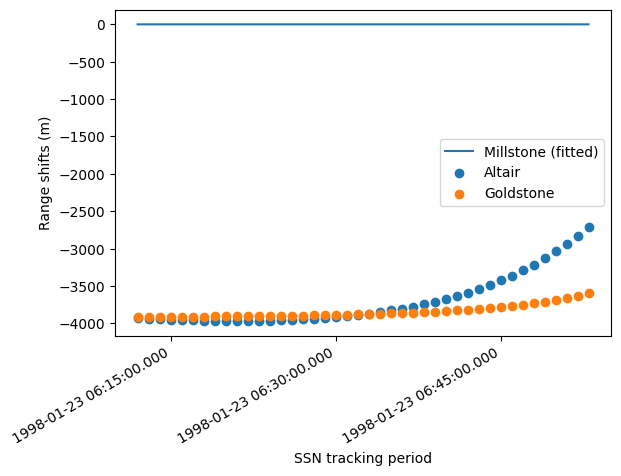

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.plot(ssn_epochs, millstone_shifts, label="Millstone (fitted)")
    plt.scatter(ssn_epochs, altair_shifts, label="Altair")
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

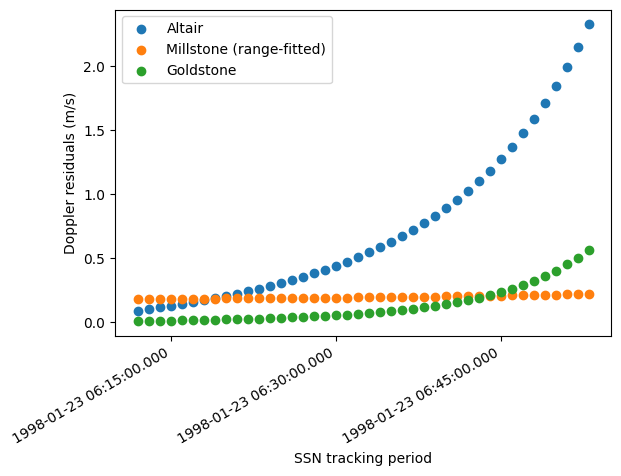

In [12]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, altair_doppler, label="Altair")
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone (range-fitted)")
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()